# Setup

In [1]:
import os
import pickle
from datetime import datetime, timedelta

import numpy as np
import pandas as pd
import h5py

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras

import wandb
from wandb.keras import WandbCallback

from IPython.display import display

from pwas.shared_utils.util import start_log, log, get_chunk_intervals
    
def mkdir_if_not_exists(directory):
    if not os.path.isdir(directory):
        os.mkdir(directory)

In [2]:
start_log('/cs/phd/nadavb/logs', 'protobert_pretraining')

Creating log file: protobert_pretraining__22630__2020_08_30-15:11:18.txt


In [3]:
tf.test.is_gpu_available()

True

In [4]:
wandb.init(project = 'protobert', dir = '/cs/phd/nadavb/my_storage/wandb')#, resume = 'expert-dragon-23')

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


W&B Run: https://app.wandb.ai/nadavb/protobert/runs/2t9mt9hp

# Data processing and model training

8943 unique annotations.


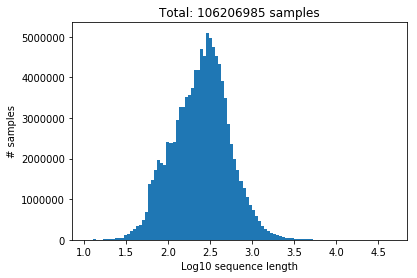

In [5]:
H5_FILE_PATH = '/cs/phd/nadavb/cafa_project/data/dataset.h5'
BASE_WEIGHTS_DIR = '/cs/phd/nadavb/cafa_project/data/model_weights'

run_weights_dir = os.path.join(BASE_WEIGHTS_DIR, wandb.run.name)
mkdir_if_not_exists(run_weights_dir)
auto_save_weights_dir = os.path.join(run_weights_dir, 'autosave')
mkdir_if_not_exists(auto_save_weights_dir)

with h5py.File(H5_FILE_PATH, 'r') as h5f:
    
    included_annotation_indices = h5f['included_annotation_indices'][:]
    
    fig, ax = plt.subplots()
    ax.hist(np.log10(h5f['seq_lengths'][:]), bins = 100)
    ax.set_xlabel('Log10 sequence length')
    ax.set_ylabel('# samples')
    ax.set_title('Total: %d samples' % len(h5f['seq_lengths']))
    
n_annotations = len(included_annotation_indices)
print('%d unique annotations.' % n_annotations)

In [6]:
import tensorflow.keras.backend as K

class OneHotEncoding(keras.layers.Layer):
    
    def __init__(self, vocab_size, **kwargs):
        self.vocab_size = vocab_size
        super(OneHotEncoding, self).__init__(**kwargs)
    
    def compute_output_shape(self, input_shape):
        return input_shape + (self.vocab_size,)

    def call(self, X):
        return K.one_hot(X, self.vocab_size)

class GlobalAttention(keras.layers.Layer):
    
    '''
    Recevies two inputs:
    1. A global representation (of some fixed dimension)
    2. A sequence (of any length, and some fixed dimension)
    The global representation is used to construct a global query that attends to all the positions in the sequence (independently
    for any of the heads).
    '''
    
    def __init__(self, n_heads, d_key, d_value, **kwargs):
        self.n_heads = n_heads
        self.d_key = d_key
        self.sqrt_d_key = np.sqrt(self.d_key)
        self.d_value = d_value
        self.d_output = n_heads * d_value
        super(GlobalAttention, self).__init__(**kwargs)
        
    def compute_output_shape(self, input_shapes):
        # input_shapes: (batch_size, d_global_input), (batch_size, length, d_seq_input)
        print('compute_output_shape', input_shapes) # XXX
        (batch_size, _), _ = input_shapes
        return (batch_size, self.d_output)

    def build(self, input_shapes):
        # input_shapes: (batch_size, d_global_input), (batch_size, length, d_seq_input)
        (_, self.d_global_input), (_, _, self.d_seq_input) = input_shapes
        # Wq: (n_heads, d_global_input, d_key)
        self.Wq = self.add_weight(name = 'Wq', shape = (self.n_heads, self.d_global_input, self.d_key), \
                initializer = 'glorot_uniform', trainable = True)
        # Wk: (n_heads, d_seq_input, d_key)
        self.Wk = self.add_weight(name = 'Wk', shape = (self.n_heads, self.d_seq_input, self.d_key), \
                initializer = 'glorot_uniform', trainable = True)
        # Wv: (n_heads, d_seq_input, d_value)
        self.Wv = self.add_weight(name = 'Wv', shape = (self.n_heads, self.d_seq_input, self.d_value), \
                initializer = 'glorot_uniform', trainable = True)
        super(GlobalAttention, self).build(input_shapes)

    def call(self, inputs):
        
        # X: (batch_size, d_global_input)
        # S: (batch_size, length, d_seq_input)
        X, S = inputs
        _, length, _ = K.int_shape(S)
                
        # (batch_size, n_heads, d_key)
        QX = K.tanh(K.dot(X, self.Wq))
        # (batch_size * n_heads, d_key)
        QX_batched_heads = K.reshape(QX, (-1, self.d_key))
        
        # (batch_size, n_heads, d_key, length)
        KS = K.permute_dimensions(K.tanh(K.dot(S, self.Wk)), (0, 2, 3, 1))
        # (batch_size * n_heads, d_key, length)
        KS_batched_heads = K.reshape(KS, (-1, self.d_key, length))

        # (batch_size, n_heads, length, d_value)
        VS = K.permute_dimensions(K.relu(K.dot(S, self.Wv)), (0, 2, 1, 3))
        # (batch_size * n_heads, length, d_value)
        VS_batched_heads = K.reshape(VS, (-1, length, self.d_value))
                
        # (batch_size * n_heads, length)
        Z_batched_heads = K.softmax(K.batch_dot(QX_batched_heads, KS_batched_heads) / self.sqrt_d_key)
        # (batch_size * n_heads, d_value)
        Y_batched_heads = K.batch_dot(Z_batched_heads, VS_batched_heads)
        # (batch_size, n_heads * d_value)
        Y = K.reshape(Y_batched_heads, (-1, self.d_output))
        
        return Y
    
def _create_model(seq_len, vocab_size, n_annotations, d_hidden_seq = 512, d_hidden_global = 2048, n_blocks = 6, n_heads = 8, \
         d_key = 64, conv_kernel_size = 9, wide_conv_dilation_rate = 5):
    
    '''
    seq_len is required to create the model, but all the weights are independent of the length and can be re-used with
    different lengths.
    '''
    
    assert d_hidden_global % n_heads == 0
    d_value = d_hidden_global // n_heads
    
    input_seq = keras.layers.Input(shape = (seq_len,), dtype = np.int32, name = 'input-seq')
    input_annoatations = keras.layers.Input(shape = (n_annotations,), dtype = np.float32, name = 'input-annotations')
    
    encoded_input_seq = OneHotEncoding(vocab_size, name = 'input-seq-encoding')(input_seq)
    
    hidden_seq = keras.layers.Dense(d_hidden_seq, activation = 'relu', name = 'dense-seq-input')(encoded_input_seq)
    hidden_global = keras.layers.Dense(d_hidden_global, activation = 'relu', name = 'dense-global-input')(input_annoatations)
    
    for block_index in range(1, n_blocks + 1):
        
        seqed_global = keras.layers.Dense(d_hidden_seq, activation = 'relu', name = 'global-to-seq-dense-block%d' % block_index)(hidden_global)
        seqed_global = keras.layers.Reshape((1, d_hidden_seq), name = 'global-to-seq-reshape-block%d' % block_index)(seqed_global)
        
        narrow_conv_seq = keras.layers.Conv1D(filters = d_hidden_seq, kernel_size = conv_kernel_size, strides = 1, \
                padding = 'same', dilation_rate = 1, activation = 'relu', name = 'narrow-conv-block%d' % block_index)(hidden_seq)
        wide_conv_seq = keras.layers.Conv1D(filters = d_hidden_seq, kernel_size = conv_kernel_size, strides = 1, \
                padding = 'same', dilation_rate = wide_conv_dilation_rate, activation = 'relu', name = 'wide-conv-block%d' % \
                block_index)(hidden_seq)
        
        hidden_seq = keras.layers.Add(name = 'seq-merge1-block%d' % block_index)([hidden_seq, seqed_global, narrow_conv_seq, wide_conv_seq])
        hidden_seq = keras.layers.LayerNormalization(name = 'seq-merge1-norm-block%d' % block_index)(hidden_seq)
        
        dense_seq = keras.layers.Dense(d_hidden_seq, activation = 'relu', name = 'seq-dense-block%d' % block_index)(hidden_seq)
        hidden_seq = keras.layers.Add(name = 'seq-merge2-block%d' % block_index)([hidden_seq, dense_seq])
        hidden_seq = keras.layers.LayerNormalization(name = 'seq-merge2-norm-block%d' % block_index)(hidden_seq)
        
        dense_global = keras.layers.Dense(d_hidden_global, activation = 'relu', name = 'global-dense1-block%d' % block_index)(hidden_global)
        attention = GlobalAttention(n_heads, d_key, d_value, name = 'global-attention-block%d' % block_index)([hidden_global, hidden_seq])
        hidden_global = keras.layers.Add(name = 'global-merge1-block%d' % block_index)([hidden_global, dense_global, attention])
        hidden_global = keras.layers.LayerNormalization(name = 'global-merge1-norm-block%d' % block_index)(hidden_global)
        
        dense_global = keras.layers.Dense(d_hidden_global, activation = 'relu', name = 'global-dense2-block%d' % block_index)(hidden_global)
        hidden_global = keras.layers.Add(name = 'global-merge2-block%d' % block_index)([hidden_global, dense_global])
        hidden_global = keras.layers.LayerNormalization(name = 'global-merge2-norm-block%d' % block_index)(hidden_global)
        
    output_seq = keras.layers.Dense(vocab_size, activation = 'softmax', name = 'output-seq')(hidden_seq)
    output_annotations = keras.layers.Dense(n_annotations, activation = 'sigmoid', name = 'output-annotations')(hidden_global)

    return keras.models.Model(inputs = [input_seq, input_annoatations], outputs = [output_seq, output_annotations])

In [ ]:
EPISODE_SETTINGS = [
    # max_seq_len, batch_size
    (100, 128),
    (450, 64),
    (1200, 32),
]

ALL_AAS = 'ACDEFGHIKLMNPQRSTUVWXY'
ADDITIONAL_TOKENS = ['<OTHER>', '<START>', '<END>', '<PAD>']

# Each sequence is added <START> and <END> tokens
ADDED_TOKENS_PER_SEQ = 2

n_aas = len(ALL_AAS)
aa_to_token_index = {aa: i for i, aa in enumerate(ALL_AAS)}
additional_token_to_index = {token: i + len(ALL_AAS) for i, token in enumerate(ADDITIONAL_TOKENS)}
token_to_index = {**aa_to_token_index, **additional_token_to_index}
index_to_token = {index: token for token, index in token_to_index.items()}
n_tokens = len(token_to_index)

def tokenize_seq(seq):
    other_token_index = additional_token_to_index['<OTHER>']
    return [additional_token_to_index['<START>']] + [aa_to_token_index.get(aa, other_token_index) for aa in seq] + \
            [additional_token_to_index['<END>']]

def create_model(max_seq_len):
    global n_tokens, n_annotations
    K.clear_session()
    return _create_model(seq_len = max_seq_len, vocab_size = n_tokens, n_annotations = n_annotations)

def recreate_model_with_same_state(old_model, create_and_compile_model_funtion):
    model_weights, optimizer_weights = old_model.get_weights(), old_model.optimizer.get_weights()
    new_model = create_and_compile_model_funtion()
    new_model.set_weights(model_weights)
    new_model.optimizer.set_weights(optimizer_weights)
    return new_model

def save_model(model, path):
    with open(path, 'wb') as f:
        pickle.dump((model.get_weights(), model.optimizer.get_weights()), f)
        
def load_model(model, path):
    with open(path, 'rb') as f:
        model_weights, optimizer_weights = pickle.load(f)
        model.set_weights(model_weights)
        model.optimizer.set_weights(optimizer_weights)

class SampleCache:
    
    def __init__(self, seqs = [], annotation_masks = [], test_set_flags = []):
        self.seqs = list(seqs)
        self.annotation_masks = list(annotation_masks)
        self.test_set_flags = list(test_set_flags)
        
    def extend(self, other_cache):
        self.seqs.extend(other_cache.seqs)
        self.annotation_masks.extend(other_cache.annotation_masks)
        self.test_set_flags.extend(other_cache.test_set_flags)
        
    def pop(self, n):
        popped_sample_cache = self.slice_first(n)
        self.seqs = self.seqs[n:]
        self.annotation_masks = self.annotation_masks[n:]
        self.test_set_flags = self.test_set_flags[n:]
        return popped_sample_cache
    
    def slice_first(self, n):
        return SampleCache(self.seqs[:n], self.annotation_masks[:n], self.test_set_flags[:n])
        
    def slice_indices(self, indices):
        return SampleCache([self.seqs[i] for i in indices], [self.annotation_masks[i] for i in indices], \
                [self.test_set_flags[i] for i in indices])
    
    def __len__(self):
        assert len(self.seqs) == len(self.annotation_masks) == len(self.test_set_flags)
        return len(self.seqs)
    
class DatasetHandler:
    
    def __init__(self, dataset_h5f):
        self.dataset_h5f = dataset_h5f
        self.total_size = len(h5f['seq_lengths'])
        
    def __getitem__(self, slicing):
        return SampleCache(self.dataset_h5f['seqs'][slicing], self.dataset_h5f['annotation_masks'][slicing], \
                self.dataset_h5f['test_set_similarity'][slicing])

class EpisodeDataManager:
    
    def __init__(self, max_seq_len, batch_size, batches_per_epoch):
        self.max_seq_len = max_seq_len
        self.batch_size = batch_size
        self.batches_per_epoch = batches_per_epoch
        self.epoch_size = self.batches_per_epoch * self.batch_size
        self.sample_cache = SampleCache()
        
    def is_epoch_ready(self, n_required_samples = None):
        return len(self.sample_cache) >= self._resolve_epoch_size(n_required_samples)
    
    def get_next_raw_epoch(self, size = None):
        return self.sample_cache.pop(self._resolve_epoch_size(size))
    
    def peek_raw_epoch(self, size = None):
        return self.sample_cache.slice_first(self._resolve_epoch_size(size))
    
    def encode_next_epoch(self, log_length_dist = True):
        
        seq_lengths, encoded_seqs, encoded_annotation_masks = self._encode_epoch(self.get_next_raw_epoch())
        
        if log_length_dist:
            log('Epoch sequence length distribution (for max_seq_len = %d): %s' % (self.max_seq_len, \
                    ', '.join('%s: %s' % item for item in pd.Series(seq_lengths).describe().iteritems())))
        
        return encoded_seqs, encoded_annotation_masks
    
    def encode_dummy_epoch(self, size = 1):
        seq_lengths, encoded_seqs, encoded_annotation_masks = self._encode_epoch(self.peek_raw_epoch(size))
        return encoded_seqs, encoded_annotation_masks
    
    def _encode_epoch(self, epoch_sample_cache):
        
        pad_token_index = additional_token_to_index['<PAD>']
        tokenized_seqs = list(map(tokenize_seq, epoch_sample_cache.seqs))
        seq_lengths = np.array(list(map(len, tokenized_seqs)))
        max_offsets = np.maximum(seq_lengths - self.max_seq_len, 0)
        chosen_offsets = (np.random.rand(self.epoch_size) * (max_offsets + 1)).astype(int)
        trimmed_tokenized_seqs = [seq_tokens[chosen_offset:(chosen_offset + self.max_seq_len)] for seq_tokens, chosen_offset in \
                zip(tokenized_seqs, chosen_offsets)]
        encoded_seqs = np.array([seq_tokens + max(self.max_seq_len - len(seq_tokens), 0) * [pad_token_index] for seq_tokens in \
                trimmed_tokenized_seqs]).astype(np.int8)
        
        encoded_annotation_masks = np.concatenate([annotation_mask.reshape(1, -1) for annotation_mask in \
                epoch_sample_cache.annotation_masks], axis = 0).astype(bool)
        encoded_annotation_masks[epoch_sample_cache.test_set_flags, :] = False
        
        return seq_lengths, encoded_seqs, encoded_annotation_masks
    
    def _resolve_epoch_size(self, size):
        if size is None:
            return self.epoch_size
        else:
            return size
    
class EpochGenerator:
    
    def __init__(self, batches_per_epoch = 100, p_seq_noise = 0.05, p_no_input_annot = 0.5, p_annot_noise_positive = 0.25, \
            p_annot_noise_negative = 1e-04, load_chunk_size = 100000, min_time_per_episode = timedelta(minutes = 15)):
        
        self.batches_per_epoch = batches_per_epoch
        self.p_seq_noise = p_seq_noise
        self.p_no_input_annot = p_no_input_annot
        self.p_annot_noise_positive = p_annot_noise_positive
        self.p_annot_noise_negative = p_annot_noise_negative
        self.load_chunk_size = load_chunk_size
        self.min_time_per_episode = min_time_per_episode
        
        self.episode_managers = [EpisodeDataManager(max_seq_len, batch_size, self.batches_per_epoch) for max_seq_len, batch_size in \
                EPISODE_SETTINGS]
        self.episode_max_seq_lens = np.array([episode_manager.max_seq_len for episode_manager in self.episode_managers])
        
    def setup(self, dataset_handler, starting_sample_index = 0):
        self.dataset_handler = dataset_handler
        self.current_sample_index = starting_sample_index % self.dataset_handler.total_size
        self._load_chunk()
        self._select_new_episode()
        return self._current_episode
    
    def determine_episode_and_ready_next_epoch(self):
        
        if self._episode_selection_time + self.min_time_per_episode <= datetime.now():
            old_episode = self._current_episode
            self._select_new_episode()
            changed_episode = (self._current_episode is not old_episode)
        else:
            changed_episode = False
            
        while not self._current_episode.is_epoch_ready():
            self._load_chunk()

        return changed_episode, self._current_episode
        
    def create_next_epoch(self):
        return self._encode_epoch(*self.create_next_epoch_X())
        
    def create_dummpy_epoch(self, size = 1):
        return self._encode_epoch(*self.create_next_dummy_epoch_X(size))
        
    def create_next_epoch_X(self):
        assert self._current_episode.is_epoch_ready()
        return self._current_episode.encode_next_epoch()
    
    def create_next_dummy_epoch_X(self, size = 1):
        
        while not self._current_episode.is_epoch_ready(size):
            self._load_chunk()
            
        return self._current_episode.encode_dummy_epoch(size)
    
    def _select_new_episode(self):
        self._current_episode = max(self.episode_managers, key = lambda episode_manager: len(episode_manager.sample_cache))
        self._episode_selection_time = datetime.now()
            
    def _load_chunk(self):
        
        chunk_sample_cache = self.dataset_handler[self.current_sample_index:(self.current_sample_index + self.load_chunk_size)]
        self.current_sample_index += self.load_chunk_size
        
        if self.current_sample_index >= self.dataset_handler.total_size:
            self.current_sample_index = 0
            
        self._assign_samples(chunk_sample_cache)
        
    def _assign_samples(self, sample_cache):
        
        seq_lens = np.array(list(map(len, sample_cache.seqs))) + ADDED_TOKENS_PER_SEQ
        assigned_episode_indices = self._select_episodes_to_assign(seq_lens)
        
        for episode_manager_index, episode_manager in enumerate(self.episode_managers):
            sample_indices_for_episode, = np.where(assigned_episode_indices == episode_manager_index)
            episode_manager.sample_cache.extend(sample_cache.slice_indices(sample_indices_for_episode))
        
    def _select_episodes_to_assign(self, seq_lens, gamma = 1):
        # The smaller the distance between a sample's sequence length to an episode's maximum sequence length, the higher the chance
        # that it will be assigned to that episode.
        samples_by_episodes_seq_len_ratio = seq_lens.reshape(-1, 1) / self.episode_max_seq_lens.reshape(1, -1)
        samples_by_episodes_seq_len_symmetric_ratio = np.maximum(samples_by_episodes_seq_len_ratio, 1 / samples_by_episodes_seq_len_ratio)
        raw_samples_by_episodes_probs = np.exp(-gamma * samples_by_episodes_seq_len_symmetric_ratio)
        samples_by_episodes_probs = raw_samples_by_episodes_probs / raw_samples_by_episodes_probs.sum(axis = -1).reshape(-1, 1)
        samples_by_episodes_cum_probs = samples_by_episodes_probs.cumsum(axis = -1)
        assigned_episode_indices = (np.random.rand(len(seq_lens), 1) <= samples_by_episodes_cum_probs).argmax(axis = 1)
        return assigned_episode_indices
    
    def _encode_epoch(self, encoded_seqs, encoded_annotation_masks):
        
        seqs_noise_mask = np.random.choice([True, False], encoded_seqs.shape, p = [1 - self.p_seq_noise, self.p_seq_noise])
        random_seq_tokens = np.random.randint(0, n_tokens, encoded_seqs.shape)
        noisy_encoded_seqs = np.where(seqs_noise_mask, encoded_seqs, random_seq_tokens)

        noisy_annotations_when_positive = np.random.choice([True, False], encoded_annotation_masks.shape, \
                p = [1 - self.p_annot_noise_positive, self.p_annot_noise_positive])
        noisy_annotations_when_negative = np.random.choice([True, False], encoded_annotation_masks.shape, \
                p = [self.p_annot_noise_negative, 1 - self.p_annot_noise_negative])
        noisy_annotation_masks = np.where(encoded_annotation_masks, noisy_annotations_when_positive, \
                noisy_annotations_when_negative)
        noisy_annotation_masks[np.random.choice([True, False], len(noisy_annotation_masks), p = [self.p_no_input_annot, \
                1 - self.p_no_input_annot]), :] = False

        # When a protein has no annotations at all, we don't know whether it's because such annotations don't exist or just not found,
        # so it's safer to set the loss weight of those annotations to zero.
        seq_weights = np.ones(len(encoded_seqs))
        annotation_weights = encoded_annotation_masks.any(axis = -1).astype(float)
        
        X = [noisy_encoded_seqs, noisy_annotation_masks.astype(np.int8)]
        Y = [np.expand_dims(encoded_seqs, axis = -1), encoded_annotation_masks.astype(np.int8)]
        sample_weigths = [seq_weights, annotation_weights]
        
        return X, Y, sample_weigths
    
class AutoSaveManager:
    
    def __init__(self, directory, every_epochs_to_save = 1, every_saves_to_keep = 25):
        self.directory = directory
        self.every_epochs_to_save = every_epochs_to_save
        self.every_saves_to_keep = every_saves_to_keep
        self.last_saved_path_to_delete = None
        self.n_saves = 0
    
    def on_epoch_end(self, model, epoch_index, sample_index):
        
        if epoch_index % self.every_epochs_to_save != 0:
            return
        
        save_path = os.path.join(self.directory, 'epoch_%d_sample_%d.pkl' % (epoch_index, sample_index))
        save_model(model, save_path)
        self.n_saves += 1
        
        if self.last_saved_path_to_delete is not None:
            os.remove(self.last_saved_path_to_delete)
            
        if self.n_saves % self.every_saves_to_keep == 0:
            self.last_saved_path_to_delete = None
        else:
            self.last_saved_path_to_delete = save_path
    
class ModelTrainer:
    
    def __init__(self, epoch_generator, autosave_manager, lr = 2e-04, annots_loss_weight = 1e03):
        self.epoch_generator = epoch_generator
        self.autosave_manager = autosave_manager
        self.lr = lr
        self.annots_loss_weight = annots_loss_weight
        
    def setup(self, dataset_handler, resume_epoch = None):
        
        if resume_epoch is None:
            self.current_epoch_index = 0
            starting_sample_index = 0
            resumed_weights_file_path = None
        else:
            self.current_epoch_index, starting_sample_index = resume_epoch
            self.current_epoch_index += 1
            resumed_weights_file_path = os.path.join(run_weights_dir, 'epoch_%d_sample_%d.pkl' % resume_epoch)
        
        starting_episode = self.epoch_generator.setup(dataset_handler, starting_sample_index)
        log('Starting with episode with max_seq_len = %d.' % starting_episode.max_seq_len)
        
        self.model = self._get_create_and_compile_model_function(starting_episode.max_seq_len, will_weights_be_reloaded = \
                (resumed_weights_file_path is not None))()
        self.model.summary()
        
        if resumed_weights_file_path is not None:
            load_model(self.model, resumed_weights_file_path)
            log('Loaded weights from %s.' % resumed_weights_file_path)
        
    def train_next_epoch(self, autosave_if_needed = True):
        
        changed_episode, episode = self.epoch_generator.determine_episode_and_ready_next_epoch()
        
        if changed_episode:
            log('Starting a new episode with max_seq_len = %d.' % episode.max_seq_len)
            self.model = recreate_model_with_same_state(self.model, self._get_create_and_compile_model_function(episode.max_seq_len, \
                    will_weights_be_reloaded = True))
        
        X, Y, sample_weigths = self.epoch_generator.create_next_epoch()
        log('Epoch %d (current sample %d):' % (self.current_epoch_index, self.epoch_generator.current_sample_index))
        self.model.fit(X, Y, sample_weight = sample_weigths, batch_size = episode.batch_size, callbacks = [WandbCallback()])
        
        if autosave_if_needed:
            self.autosave_manager.on_epoch_end(self.model, self.current_epoch_index, self.epoch_generator.current_sample_index)
            
        self.current_epoch_index += 1
        
    def train_forever(self, autosave = True):
        while True:
            self.train_next_epoch(autosave_if_needed = autosave)
            
    def _get_create_and_compile_model_function(self, max_seq_len, will_weights_be_reloaded = False):
        
        def create_and_compile_model_function():
            
            model = create_model(max_seq_len)
            self._compile_model(model)
            
            if will_weights_be_reloaded:
                self._train_for_a_dummy_epoch(model)
            
            return model
        
        return create_and_compile_model_function
    
    def _compile_model(self, model):
        model.compile(optimizer = keras.optimizers.Adam(lr = self.lr), loss = ['sparse_categorical_crossentropy', \
                'binary_crossentropy'], loss_weights = [1, self.annots_loss_weight])
        
    def _train_for_a_dummy_epoch(self, model):
        '''
        For some reason keras requires this strange little hack in order to properly initialize a new model's optimizer, so that
        the optimizer's weights can be reloaded from an existing state.
        '''
        X, Y, sample_weigths = self.epoch_generator.create_dummpy_epoch(size = 1)
        model.fit(X, Y, batch_size = 1, verbose = 0)
        
# RESUME_EPOCH = None
RESUME_EPOCH = (50, 600000)
        
np.random.seed(0)
epoch_generator = EpochGenerator()
autosave_manager = AutoSaveManager(auto_save_weights_dir, every_epochs_to_save = 10)
model_trainer = ModelTrainer(epoch_generator, autosave_manager)

with h5py.File(H5_FILE_PATH, 'r') as h5f:
    model_trainer.setup(DatasetHandler(h5f), resume_epoch = RESUME_EPOCH)
    model_trainer.train_forever()

[2020_08_30-17:56:17] Starting with episode with max_seq_len = 450.
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input-seq (InputLayer)          [(None, 450)]        0                                            
__________________________________________________________________________________________________
input-annotations (InputLayer)  [(None, 8943)]       0                                            
__________________________________________________________________________________________________
input-encoding (OneHotEncoding) (None, 450, 26)      0           input-seq[0][0]                  
__________________________________________________________________________________________________
dense-global-input (Dense)      (None, 2048)         18317312    input-annotations[0][0]          
__________________________

Failed to query for notebook name, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable
wandb: Wandb version 0.9.6 is available!  To upgrade, please run:
wandb:  $ pip install wandb --upgrade


6400/6400 [==============================] - 81s 13ms/sample - loss: 0.6886 - output-seq_loss: 0.2157 - output-annotations_loss: 4.7287e-04
[2020_08_30-17:57:47] Epoch sequence length distribution (for max_seq_len = 450): count: 6400.0, mean: 377.8171875, std: 182.24120862176338, min: 62.0, 25%: 256.0, 50%: 339.0, 75%: 455.0, max: 2321.0
[2020_08_30-17:57:49] Epoch 52 (current sample 700000):
Train on 6400 samples
6400/6400 [==============================] - 78s 12ms/sample - loss: 0.7039 - output-seq_loss: 0.2156 - output-annotations_loss: 4.8829e-04
[2020_08_30-17:59:08] Epoch sequence length distribution (for max_seq_len = 450): count: 6400.0, mean: 374.47359375, std: 174.7462731171398, min: 65.0, 25%: 258.0, 50%: 338.5, 75%: 450.0, max: 2085.0
[2020_08_30-17:59:09] Epoch 53 (current sample 700000):
Train on 6400 samples
6400/6400 [==============================] - 79s 12ms/sample - loss: 0.6925 - output-seq_loss: 0.2145 - output-annotations_loss: 4.7794e-04
[2020_08_30-18:00:28] Ep

# Validation on test-set samples

(The code is somewhat patchy)

In [ ]:
N = 10

with h5py.File(H5_FILE_PATH, 'r') as h5f:
    test_set_indices, = np.where(h5f['test_set_similarity'][:])
    chosen_sample_indices = list(sorted(np.random.choice(test_set_indices, N)))
    del test_set_indices
    chosen_samples = DatasetHandler(h5f)[chosen_sample_indices]
    chosen_uniprot_ids = h5f['uniprot_ids'][chosen_sample_indices]
    
# So that true annotations won't be masked away here.
chosen_samples.test_set_flags = [False for _ in range(N)]
    
seq_lens = np.array(list(map(len, chosen_samples.seqs)))
max_seq_len = seq_lens.max()
model_max_seq_len = min(max_seq_len, 1000)
model_max_seq_len = 450 # We end up just forcing 450.
log('max_seq_len = %d, model_max_seq_len = %d' % (max_seq_len, model_max_seq_len))

episode = EpisodeDataManager(model_max_seq_len, batch_size = 1, batches_per_epoch = 1)
episode.sample_cache = chosen_samples
epoch_generator._current_episode = episode

model = recreate_model_with_same_state(model_trainer.model, model_trainer._get_create_and_compile_model_function(model_max_seq_len, \
        will_weights_be_reloaded = True))
    
for uniprot_id in chosen_uniprot_ids:
    
    print('UniProt ID: %s (https://www.uniprot.org/uniprot/%s)' % (uniprot_id, uniprot_id))

    X, Y_true, _ = epoch_generator._encode_epoch(*episode.encode_next_epoch())
    Y_pred = model.predict(X)
    
    X_seqs, X_annots = X
    Y_true_seqs, Y_true_annots = Y_true
    Y_pred_seqs, Y_pred_annots = Y_pred

    X_seqs = X_seqs.flatten()
    X_annots = X_annots.flatten()
    Y_true_seqs = Y_true_seqs.flatten()
    Y_true_annots = Y_true_annots.flatten()
    Y_pred_seqs = Y_pred_seqs[0, :, :]
    Y_pred_annots = Y_pred_annots.flatten()
    Y_pred_seqs_max = Y_pred_seqs.argmax(axis = -1)

    seq_result = pd.DataFrame()
    seq_result['true'] = list(map(index_to_token.get, Y_true_seqs))
    seq_result['input'] = list(map(index_to_token.get, X_seqs))
    seq_result['max'] = list(map(index_to_token.get, Y_pred_seqs_max))
    seq_result['p_true'] = Y_pred_seqs[np.arange(model_max_seq_len), Y_true_seqs]
    seq_result['p_input'] = Y_pred_seqs[np.arange(model_max_seq_len), X_seqs]
    seq_result['p_max'] = Y_pred_seqs[np.arange(model_max_seq_len), Y_pred_seqs_max]

    print('Sequence results:')

    with pd.option_context('display.max_columns', model_max_seq_len):
        display(seq_result[(seq_result['true'] != seq_result['input']) | (seq_result['p_true'] < 0.9)].transpose())

    true_annots, = np.where(Y_true_annots)
    input_annots, = np.where(X_annots)
    relevant_annots = sorted(set(true_annots) | set(input_annots) | set(np.where(Y_pred_annots >= 0.05)[0]))

    print('Annotation results:')
    print('True annotations: %s' % true_annots)
    print('Input annotations: %s' % input_annots)
    print('Predicted annotations: %s' % ', '.join('%d (%.2g)' % (annot, Y_pred_annots[annot]) for annot in relevant_annots))

In [ ]:
# XXX Check the consistency of the model after reloading the weights.

def create_and_compile_model_function():
    global model_max_seq_len, model_trainer, X, Y_true
    model = create_model(model_max_seq_len)
    model_trainer._compile_model(model)
    model.fit(X, Y_true, batch_size = 1, verbose = 0)
    return model

def train_model(model):
    
    global X, Y_true

    for _ in range(10):
        model.fit(X, Y_true, batch_size = 1, verbose = 0)

train_model(model)

model1 = recreate_model_with_same_state(model, create_and_compile_model_function)
train_model(model1)
Y_pred1 = model1.predict(X)

model2 = recreate_model_with_same_state(model, create_and_compile_model_function)
train_model(model2)
Y_pred2 = model2.predict(X)

for y_pred1, y_pred2 in zip(Y_pred1, Y_pred2):
    print(np.abs(y_pred1 - y_pred2).max())